In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAperture
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std

In [6]:
surveys={'SDSS':glob('./SDSS/*.fits'),
         '2MASS':glob('./2MASS/*.fits'),
         'GALEX':glob('./GALEX/*'),
         'WISE':glob('./WISE/*')}
targets={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9379': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}

#print(surveys)

In [ ]:

image=fits.open(surveys[survey][0])[0].data
hdr=fits.open(surveys[survey][0])[0].header
wcs=WCS(hdr)
hdr['FILTNAME']

'u'

## SDSS ##

./SDSS/MCG06.fits
u_S/N 9.960923567526754
u_Mag= 15.854793946514523  dM= 0.1003922972825596
i_S/N 43.495240744182496
i_Mag= 14.06012513482455  dM=  0.022991021152900512
z_S/N 41.803251887714914
z_Mag= 13.914906439180083  dM=  0.023921583963994884


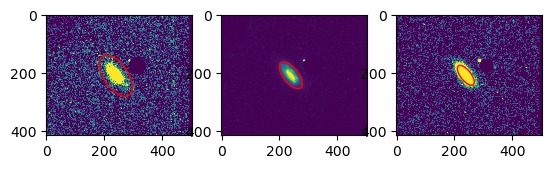

In [ ]:
obj_ind=1
survey='SDSS'

print(surveys[survey][obj_ind])
target=surveys[survey][obj_ind].split('/')[-1].split('.')[0]
target_x,target_y=wcs.world_to_pixel(targets[target])
u_hdr=fits.open(surveys[survey][obj_ind])[0].header
i_hdr=fits.open(surveys[survey][obj_ind])[3].header
z_hdr=fits.open(surveys[survey][obj_ind])[4].header
wcs=WCS(u_hdr)
u_im=fits.open(surveys[survey][obj_ind])[0].data.byteswap().newbyteorder()
i_im=fits.open(surveys[survey][obj_ind])[3].data.byteswap().newbyteorder()
z_im=fits.open(surveys[survey][obj_ind])[4].data.byteswap().newbyteorder()
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(u_im,vmin=0,vmax=20*np.median(u_im))
ax2.imshow(i_im,vmin=0,vmax=200*np.median(i_im))
ax3.imshow(z_im,vmin=0,vmax=300*np.median(z_im))


u_bkg_mean,u_bkg_med,u_bkg_rms=sigma_clipped_stats(u_im[0:150,0:150])
u_objects= sep.extract(u_im,0.3,err=u_bkg_rms)
ind=np.argmax([el[15]*el[16] for el in u_objects])
x=u_objects['x'][ind]
y=u_objects['y'][ind]
a=u_objects['a'][ind]
b=u_objects['b'][ind]
theta=u_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(u_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(u_im, aper)
net=phot_table['aperture_sum'][0]
SN_gal=net/np.sqrt(net+aper.area*u_bkg_rms)
print('u_S/N',SN_gal)
print('u_Mag=',-2.5*np.log10(float(net))+22.5,' dM=',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax1.add_artist(e_app)

i_bkg_mean,i_bkg_med,i_bkg_rms=sigma_clipped_stats(i_im[0:150,0:150])
i_objects= sep.extract(i_im, i_bkg_med+2*i_bkg_rms)#use if no blending wanted
#print(i_objects['x'])
ind=np.argmin([np.sqrt((i_objects['x'][el]-len(i_im[0])/2)**2+(i_objects['y'][el]-len(i_im)/2)**2) for el in range(len(i_objects))])
x=i_objects['x'][ind]
y=i_objects['y'][ind]
a=i_objects['a'][ind]
b=i_objects['b'][ind]
theta=i_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(i_im, [x], [y], [a], [b], [theta], 8.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(i_im, aper)
net=phot_table['aperture_sum'][0]
SN_gal=net/np.sqrt(net+aper.area*i_bkg_rms)
print('i_S/N',SN_gal)
print('i_Mag=',-2.5*np.log10(float(net))+22.5,' dM= ',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax2.add_artist(e_app)

z_bkg_mean,z_bkg_med,z_bkg_rms=sigma_clipped_stats(z_im[0:150,0:150])
z_objects= sep.extract(z_im, z_bkg_med+2*z_bkg_rms)#use if no blending wanted
#print(z_objects['x'])
ind=np.argmin([np.sqrt((z_objects['x'][el]-len(z_im[0])/2)**2+(z_objects['y'][el]-len(z_im)/2)**2) for el in range(len(z_objects))])
x=z_objects['x'][ind]
y=z_objects['y'][ind]
a=z_objects['a'][ind]
b=z_objects['b'][ind]
theta=z_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(z_im, [x], [y], [a], [b], [theta], 8.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(z_im, aper)
net=phot_table['aperture_sum'][0]
SN_gal=net/np.sqrt(net+aper.area*z_bkg_rms)
print('z_S/N',SN_gal)
print('z_Mag=',-2.5*np.log10(float(net))+22.5,' dM= ',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax3.add_artist(e_app)


## GALEX ##

./GALEX/UGC9379
nuv_S/N 51.01130599524587
nuv_Mag= 16.645149500329996  dM= 0.01960349731279567
nuv_S/N 25.58934377423379
fuv_Mag= 16.883185969056235  dM= 0.039078766881349716


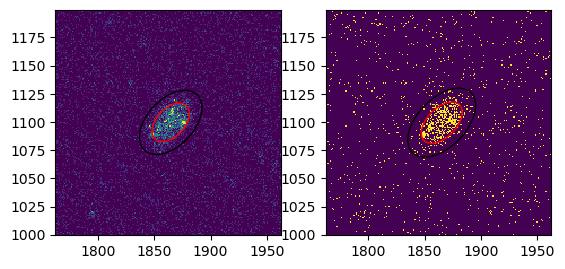

In [7]:
survey='GALEX'
obj_ind=6
obj_fold=surveys[survey][obj_ind]
obj_name=obj_fold.split('/')[-1]
print(obj_fold)
files=glob(obj_fold+'/*')
fuv_im=fits.open([file for file in files if file.endswith('fd-int.fits')][0])[0].data
hdr_nuv=fits.open([file for file in files if file.endswith('nd-int.fits')][0])[0].header
hdr_fuv=fits.open([file for file in files if file.endswith('fd-int.fits')][0])[0].header
nuv_im=fits.open([file for file in files if file.endswith('nd-int.fits')][0])[0].data
fuv_bkg=fits.open([file for file in files if file.endswith('fd-skybg.fits')][0])[0].data
nuv_bkg=fits.open([file for file in files if file.endswith('nd-skybg.fits')][0])[0].data
nuv_expt=float(hdr_nuv['EXPTIME'])
fuv_expt=float(hdr_fuv['EXPTIME'])
f_bkg=sigma_clipped_stats(fuv_bkg)[1]
n_bkg=sigma_clipped_stats(nuv_bkg)[1]
wcs=WCS(hdr_nuv)
fuv1=fuv_im-fuv_bkg
fuv=fuv1
nuv1=nuv_im-nuv_bkg
nuv=nuv1
target_x,target_y=wcs.world_to_pixel(targets[obj_name])
fig, (ax1,ax2) = plt.subplots(1, 2)
tol=100
ax1.imshow(nuv,vmin=0,vmax=0.08,interpolation='none',origin='lower')#,extent=(target_x-100,target_x+100,target_y-100,target_y+100))
ax1.set_xlim(target_x-tol,target_x+tol)
ax1.set_ylim(target_y-tol,target_y+tol)
ax2.imshow(fuv,vmin=0,vmax=0.005,interpolation='none',origin='lower')#,extent=(target_x-100,target_x+100,target_y-100,target_y+100))
ax2.set_xlim(target_x-tol,target_x+tol)
ax2.set_ylim(target_y-tol,target_y+tol)
fuv_bkg_mean,fuv_bkg_med,fuv_bkg_rms=sigma_clipped_stats(fuv)
nuv_bkg_mean,nuv_bkg_med,nuv_bkg_rms=sigma_clipped_stats(nuv)
nuv_objects= sep.extract(nuv,5,err=nuv_bkg_rms,minarea=20,deblend_cont=1)
#print(nuv_objects)
ind=np.argmin([np.sqrt((nuv_objects['x'][el]-target_x)**2+(nuv_objects['y'][el]-target_y)**2) for el in range(len(nuv_objects))])
x=nuv_objects['x'][ind]
y=nuv_objects['y'][ind]
a=nuv_objects['a'][ind]
b=nuv_objects['b'][ind]
theta=nuv_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(nuv, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(nuv, aper)
net=phot_table['aperture_sum'][0]
SN_gal=(net*nuv_expt)/np.sqrt(net*nuv_expt+aper.area*n_bkg*nuv_expt)
print('nuv_S/N',SN_gal)
print('nuv_Mag=',-2.5*np.log10(float(net))+20.08,' dM=',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax1.add_artist(e_app)
e1 = Ellipse(xy=(nuv_objects['x'][ind], nuv_objects['y'][ind]),
                width=6*nuv_objects['a'][ind],
                height=6*nuv_objects['b'][ind],
                angle=nuv_objects['theta'][ind] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('black')
ax1.add_artist(e1)


fuv_objects= sep.extract(fuv,2,err=fuv_bkg_rms,minarea=20,deblend_cont=1)
#print(nuv_objects)
ind=np.argmin([np.sqrt((fuv_objects['x'][el]-target_x)**2+(fuv_objects['y'][el]-target_y)**2) for el in range(len(fuv_objects))])
x=fuv_objects['x'][ind]
y=fuv_objects['y'][ind]
a=fuv_objects['a'][ind]
b=fuv_objects['b'][ind]
theta=fuv_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(fuv, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(fuv, aper)
net=phot_table['aperture_sum'][0]
SN_gal=(net*fuv_expt)/np.sqrt(net*fuv_expt+aper.area*f_bkg*fuv_expt)
print('nuv_S/N',SN_gal)
print('fuv_Mag=',-2.5*np.log10(float(net))+18.82,' dM=',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax2.add_artist(e_app)
e1 = Ellipse(xy=(fuv_objects['x'][ind], fuv_objects['y'][ind]),
                width=6*fuv_objects['a'][ind],
                height=6*fuv_objects['b'][ind],
                angle=fuv_objects['theta'][ind] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('black')
ax2.add_artist(e1)

## 2MASS ##

In [28]:
obj_ind=0
survey='2MASS'

print(surveys[survey][obj_ind])
target=surveys[survey][obj_ind].split('/')[-1].split('.')[0]
print(target)
hdr=fits.open(surveys[survey][obj_ind])[0].header
hdr['CTYPE2']='DEC--SIN'
wcs=WCS(hdr)
print(wcs)
target_x,target_y=wcs.world_to_pixel(targets[target],0)
J_im=fits.open(surveys[survey][obj_ind])[0].data.byteswap().newbyteorder()
H_im=fits.open(surveys[survey][obj_ind])[1].data.byteswap().newbyteorder()
K_im=fits.open(surveys[survey][obj_ind])[2].data.byteswap().newbyteorder()
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(J_im,vmin=0,vmax=20*np.median(J_im))
ax2.imshow(H_im,vmin=0,vmax=200*np.median(H_im))
ax3.imshow(K_im,vmin=0,vmax=300*np.median(K_im))

./2MASS/MCG05.fits
MCG05
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'JHKs cube'  
CRVAL : 256.7279358  30.26971817  0.0  
CRPIX : 41.0  41.0  0.0  
NAXIS : 81  81  6


ValueError: Expected the following order of world arguments: SkyCoord, Quantity